In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import requests 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pickle
import scipy.stats as stats


import pandas as pd
import numpy as np
from math import log, exp, sqrt, pi
from collections import defaultdict
import datetime as dt
import re
import yahoo_fin.options as options
import yfinance as yf
import multiprocessing

import math
import os
from scipy.stats import norm
import scipy.stats
from random import gauss
from yahoo_fin import stock_info as si
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns

def calc_greeks(s, k, sigma, t, price, r, q, payoff="calls"):
    """ return dict of greeks for the option """
    greeks = {}
    d1 = (np.log(s/k) + (r + sigma**2/2) * t) / (sigma*np.sqrt(t))
    d2 = (np.log(s/k) + (r - sigma**2/2) * t) / (sigma*np.sqrt(t))
    norm_cdf = (1 / np.sqrt(2*np.pi)) * np.exp(-d1**2 / 2)

    if payoff == "call":
        greeks["delta"] = np.exp(-q*t) * norm.cdf(d1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*snp.qrt(t)*norm_cdf) - r*k*np.exp(-r*t)*norm.cdf(d2) + q*s*np.exp(-q*t)*norm.cdf(d1)) / 365.242199 
        greeks["rho"] = (k*t*np.exp(-r*t)*norm.cdf(d2)) / 100

    elif payoff == "put":
        greeks["delta"] = np.exp(-q*t) * (norm.cdf(d1) - 1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*np.sqrt(t)*norm_cdf) + r*k*np.exp(-r*t)*norm.cdf(-d2) - q*s*np.exp(-q*t)*norm.cdf(-d1)) / 365.242199 
        greeks["rho"] = -(k*t*np.exp(-r*t)*norm.cdf(-d2)) / 100

    greeks["gamma"] = np.exp(-q*t) / (s * sigma * np.sqrt(t)) * norm_cdf
    greeks["vega"] = (s*np.exp(-q*t)*np.sqrt(t) * norm_cdf) / 100

    return greeks


def ticker_history(ticker, window=126, end=None, days_offset=730):  # UNDERSTAND ANN. VOL :)
    ticker_obj = yf.Ticker(ticker)
    if end is None:
        end = dt.datetime.strftime(dt.datetime.today(), "%Y-%m-%d") 
        
    start = dt.datetime.strftime(dt.datetime.today() - dt.timedelta(days_offset), "%Y-%m-%d")
        
    data = ticker_obj.history(period='1d', start=start, end=end)
    data["returns"] = data["Close"].pct_change()
    data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1))
    data["rolling_std"] = data["log_returns"].rolling(window).std()
    data["annualized_vol"] = data["rolling_std"] * sqrt(252) 

    return data.dropna()


def ticker_momentum(ticker, window=21):
    """ calculate momentum for underlying ticker and return price history. Defaults to 10M SMA"""
    ticker_obj = yf.Ticker(ticker)
    data = ticker_obj.history(period='1d', start='2019-1-1')
    data[f"sma_{window}"] = data["Close"].rolling(window=window).mean() # get 10 month SMA
    data["momentum"] = data["Close"] / data[f"sma_{window}"] - 1  # current vs. 10m SMA
    
    return data.iloc[-1]["momentum"]


def option_chain(ticker, exp_date, timeout=30):
    """ 
    returns option chain in the form of a dataframe
    ticker: desired underlying ticker as string. "SPY" for example
    exp_date: Desired option chain expiration date. Must be in the format YYYY-mm-dd 
    timeout: specifies the period in seconds to wait for webpage response
    """
    chrome_options = Options()
    driver = webdriver.Chrome(options=chrome_options) 
    try:
        url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-m&moneyness=allRows" # for IVP
        driver.get(url)
        
        # check for webpage response
        try:
            element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
            myElem = WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print("Loading took too much time!")

        # get the underlying HTML 
        dom = driver.page_source
        soup = BeautifulSoup(dom, "lxml")
        
        # URL requires monthly/weekly specification. Try monthly first, then weekly.
        first_string = soup.find_all("div", {"class": "middleware-wrapper"})[0].get_text().replace("\n", "")
        data_string = first_string.replace(" ", "").replace("N/A", "")  # strip of unnecessary chars
        if data_string[-8:] == "expired.":  
            print(f"Could not find monthly for {ticker} on {exp_date}. Trying Weekly.")
            url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-w&moneyness=allRows" 
            driver.get(url)
            try:
                element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
                myElem = WebDriverWait(driver, timeout).until(element_present)
            except TimeoutException:
                print("Loading took too much time!")          
                
            dom = driver.page_source
            soup = BeautifulSoup(dom, "lxml")
            
    except Exception as e:
        print(f"Trouble gathering data -- {e}")
        driver.quit()
        
    driver.quit()
    
    # Use BeautifulSoup to scrape data
    tables = soup.find_all("div", {"class": "barchart-content-block"})
    cols = ["strike", "moneyness", "bid", "midpoint", "ask", "last", "change", "pct_chg", "volume", "oi", 
            "vol/oi", "iv", "date", "links"]
    chains = []
    for i in tables:
        option_type = i.find_all("div", {"class": "block-title joined"})[0].get_text().replace("\n","")
        td = i.find_all("td")
        table_data = [t.get_text().replace("\n", "").replace("%", "").replace("+", "").replace("-","") for t in td]
        assert(len(table_data) % len(cols) == 0), "Trouble scraping data"

        table_data = [table_data[r:r+len(cols)] for r in range(0, len(table_data), len(cols))]
        df = pd.DataFrame(data=table_data, columns=cols).drop(["change", "pct_chg", "vol/oi", "date", "links"], axis=1)
        df["type"] = option_type
        chains.append(df)
    
    try:
        option_chain = pd.concat([df for df in chains], axis=0)
    except ValueError as e:
        print(f"No data from {url}")
        option_chain = None
        
    # Preprocess our data here
    option_chain["oi"] = option_chain["oi"].str.replace(",", "")
    option_chain["volume"] = option_chain["volume"].str.replace(",", "")
    for c in option_chain.columns:
        if c != "type":
            option_chain[c] = pd.to_numeric(option_chain[c], errors="coerce")
        
    option_chain = option_chain.dropna().reset_index(drop=True)
    option_chain["iv"] /= 100
    option_chain["moneyness"] /= 100  

    # Separate calls from puts and returns
    calls = option_chain.loc[option_chain["type"] == "Calls"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]
    puts = option_chain.loc[option_chain["type"] == "Puts"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]

    return calls, puts
    
# TODO: implement the improved driver wait
def iv_screen(n_most_liquid=25, timeout=30):
    # can we find some way to 'translate' IV based on expiration date?
    """
    n_most_liquid: number of ETFs we will return, sorted by trading volume. Use -1 to return all.
    """
    url = "https://www.barchart.com/options/iv-rank-percentile/etfs?page=all"
    chrome_options = Options()
#     chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options) 

    driver.get(url)
    try:
        element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
        myElem = WebDriverWait(driver, timeout).until(element_present)
    except TimeoutException:
        print("Loading took too much time!")       
        
    dom = driver.page_source
    soup = BeautifulSoup(dom, "lxml")
    driver.quit()
    
    table = soup.find_all("div", {"class": "bc-table-scrollable"})[0]
    cols = ["symbol", "name", "last", "change", "pct_change", "volume", "iv", "ivr", "ivp", "iv_high", "date", "links"]
    table_rows = table.find_all("td")
    assert(len(table_rows) % len(cols) == 0)

    table_rows = [i.get_text().replace("\n","") for i in table_rows]
    table_rows = [table_rows[i:i+len(cols)] for i in range(0, len(table_rows), len(cols))]
    screen = pd.DataFrame(data=table_rows, columns=cols)
    screen = screen.drop(["name", "change", "pct_change", "date", "links"], axis=1).iloc[:-1]
    
    # reformat for sorting capability
    screen["iv"] = screen["iv"].str.slice(0, -1).astype(float) / 100  
    screen["ivr"] = screen["ivr"].str.slice(0, -1).astype(float) / 100 
    screen["ivp"] = screen["ivp"].str.slice(0, -1).astype(float) / 100  
    screen["iv_high"] = screen["iv_high"].str.slice(0, -1)
    screen["iv_high"] = screen["iv_high"].str.replace(",", "").astype(float) / 100  
    screen["volume"] = screen["volume"].str.replace(",", "").astype(int)  
    
    if n_most_liquid == -1: 
        n_most_liquid = screen.shape[0]
    screen = screen.nlargest(n_most_liquid, "volume")
    
    return screen.sort_values("ivp", ascending=False)


In [2]:
def _comparison_feeder(ticker, exp_date, strategy, n_contracts, short_delta, wing_spread, d=None):
    strat = OptionStrategy(ticker=ticker, exp_date=exp_date, n_contracts=n_contracts)

    if strategy == "put_spread":
        _, credit_to_bpr = strat.put_spread(short_delta=short_delta, wing_spread=wing_spread, verbose=False)
    if strategy == "iron_condor":
        _, _, credit_to_bpr = strat.iron_condor(short_delta=short_delta, wing_spread=wing_spread, verbose=False)

    d[ticker] = credit_to_bpr

def credit_to_bpr_comparison(tickers, exp_date, strategy, short_delta=.3, wing_spread=5, n_contracts=1, n_jobs=-1):
    """ 
    compare credit/BPR of different tickers given the same strategy 
    n_jobs is number of cpus to use for multiprocessing. If -1, take cpu_count - 1
    """
    # need to make assumptions: e.g. wing width, delta, etc
    # output: comparison of ETFs that has a breakdown of credit per unit of risk for each. ideally IV data as well
    # e.g. Iron condor - for top 10 liquid ETFs, given a $10 spread (varying spreads?), which give us the most premium?
    # the idea is that if we can get good return with solid probabilities, we should still enter the trade,
    # although there will naturally be increased risk of IV expansion
    if n_jobs == -1:
        n_jobs = os.cpu_count() - 1
        
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    procs = []
    
    for t in tickers:
        try:
            p = multiprocessing.Process(target=_comparison_feeder, 
                                        args=(t, exp_date, strategy, n_contracts, short_delta, wing_spread, return_dict, ))
            p.start()
            procs.append(p)

        except Exception as e:
            print("Error!", e)
            p.close()       
            
    for p in procs:
        p.join()
    
    output = pd.DataFrame(zip(return_dict.keys(), return_dict.values()/100), columns=["ticker", "c/bpr"])
    iv_df = iv_screen(n_most_liquid=30)
    output = output.merge(iv_df, left_on="ticker", right_on="symbol")
    
    return output.sort_values("c/bpr", ascending=False)

In [3]:
# output = pd.read_csv("C:/Users/lbianculli/testing/options_working_out.csv").drop("Unnamed: 0", axis=1)
# output

In [4]:
screen = iv_screen(30)
screen.sort_values("ivr", ascending=False).head(10)

,symbol,last,volume,iv,ivr,ivp,iv_high
15,VXX,41.24,22173,0.9585,0.5926,0.60,1.4342
2,ARKK,103.15,126565,0.5391,0.5359,0.82,0.7196
20,EWT,59.74,12875,0.2517,0.4823,0.87,0.3406
11,XBI,123.70,27998,0.3491,0.3708,0.25,0.4748
1,QQQ,321.55,172277,0.2612,0.3521,0.51,0.4032
6,TQQQ,92.19,45117,0.6999,0.2659,0.30,1.1601
4,UVXY,4.79,63355,1.4848,0.2593,0.62,2.5223
29,ARKG,75.37,5019,0.5174,0.2576,0.65,1.0601
26,XME,45.17,8095,0.4026,0.2342,0.44,0.8402
16,EEM,53.07,19008,0.2286,0.2308,0.65,0.4488


In [5]:
def mc_asset_price(s, sigma, r, t, q, n_paths=500000, plot=True):
    """
    use monte carlo simulation with n_paths to estimate price of an option
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    """
    w = stats.norm.rvs( (r-0.5*sigma**2)*t , np.sqrt(t)*sigma, n_paths)
    future_prices = s * np.exp(w)

    future_prices = np.array(future_prices)
    skew = stats.skew(future_prices)
    
    # TODO: bring out of this function and add breakevens in red
    if plot:
        fig, ax = plt.subplots(figsize=(9,7))
        sns.set_style("darkgrid", {"axes.facecolor": ".95"});
        sns.set_context("talk")
        plt.axvline(x=s, c="g", ls="--")
        plt.xlabel("Underlying Price")
        sns.kdeplot(future_prices, ax=ax);
        print(f"Skew: {skew:.2f}\nMean: {np.mean(future_prices):.2f}\nMin: {np.min(future_prices):.2f}\nMax: {np.max(future_prices):.2f}")
    
    return future_prices


def mc_option_price(s, k, sigma, r, t, q, n_paths=100000, payoff="call"):
    """
    use monte carlo simulation with n_paths to estimate price of an option
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    """
    payoffs = []
    for i in range(n_paths):  
        s_T = generate_asset_price(s, sigma, r, t, q)
        if payoff == "call":
            payoff = max(0, s_T - k)
        else:
            payoff = max(0, k - s_T)

        payoffs.append(payoff)

    discount_factor = math.exp(-r-q*t)
    option_price = discount_factor * (sum(payoffs) / float(n_paths))

    return option_price

# put-call parity:
# call price = put price + spot - strike*exp(-r*t)
def binomial_option_price(s, k, sigma, t, r, q, n=10000, payoff="call"):
    """ use binomial option pricing method to return option value """
    d_t = t / n  # where t is portion of year
    u = np.exp(sigma * math.sqrt(d_t))
    d = 1.0 / u

    v = np.zeros(n+1)  # initialize price vector
    s_t = np.array([(s * u**j * d**(n-j)) for j in range(n+1)])  # build out final nodes

    # compounded risk-free return is = a = np.exp(r * dt)
    p = (np.exp((r - q)*d_t) - d) / (u - d)  # risk-neutral up probability
    q = 1.0 - p  # risk-neutral down probability

    # Account for potential exercision
    if payoff == "call":
        v[:] = np.maximum(s_t - k, 0.0)
    elif payoff == "put":
        v[:] = np.maximum(k - s_t, 0.0)

    for i in range(n-1, -1, -1):  # recursively find value at non-end nodes
         v[:-1] = (p*v[1:] + q*v[:-1]) * math.exp(-r*d_t)  # i dont totally understand. recursively price and discount each node 

    return v[0]


def price_comparison(s, k, sigma, t, r, q, n_paths=25000, payoff="call"):
    """ compare theoretical option prices using BS, binomial, and monte carlo methods """
    binomial_price = binomial_option_price(s, k, sigma, t, r, q, n_paths, payoff) 
    mc_price, _ = mc_option_price(s, k, sigma, r, t, n_paths=n_paths, payoff=payoff)
    
    return binomial_price, mc_price

In [6]:
# TODO: Refactor Greeks for all strategies, build put and call side into all strategies, comparison, debug BS Pricing
# Move commissions to instance-level
class OptionStrategy:
    def __init__(self, ticker="SPY", dte=None, exp_date=None, vol_window=21, n_contracts=1):
        if exp_date is None and dte:  # if dte is provided, we can get the exp_date
            today = dt.datetime.today()
            exp_date_dt = today + dt.timedelta(dte)
            exp_date = dt.datetime.strftime(exp_date_dt, "%Y-%m-%d")

        if dte is None and exp_date:  # likewise, if expiration is provided we can get t ourselves
            today = dt.datetime.today()
            self.dte = (dt.datetime.strptime(exp_date, "%Y-%m-%d") - today).days + 1
        print(f"{self. dte} days until expiration.")
        
        dpm = 365.25/12
        self.t = self.dte / 365.25  # get fraction of year
        self.exp_date = exp_date
        self.r = self._risk_free(self.t*365.25/dpm)  # get interpolated risk free rate (where input is # of months)
        self.ticker = ticker
        self.n_contracts = n_contracts
        
        self.hist = ticker_history(self.ticker, days_offset=730, window=vol_window)
        self.sigma = self.hist.iloc[-1]["annualized_vol"]
        
        self._get_div()
        self.calls, self.puts = option_chain(self.ticker, self.exp_date)

    def iron_condor(self, short_delta=.2, spread=5, commissions=0.6, vol_window=21, n_paths=100000, verbose=True, plot=False):
        """ Gets chain for Iron condor and returns summary """        
        total_commissions = commissions * self.n_contracts * 4
        spot = si.get_live_price(self.ticker)

        #TODO apply get_greeks. Does it take too long?
        calls, puts = option_chain(self.ticker, self.exp_date)
        calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + 
                                             (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))

        puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                           (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)

        calls["spot_diff"] = abs(calls["strike"] - spot)
        atm_strike = calls.loc[calls["spot_diff"] == calls["spot_diff"].min()].iloc[-1]

        if short_delta:
            # get OTM strikes based on delta. First calculate short side, then find long side based on nearest 
            # strike according to wing_spread
            calls["delta_diff"] = abs(calls["delta"] - short_delta)
            puts["delta_diff"] = abs(puts["delta"] + short_delta)

            short_call =  calls.loc[calls["delta_diff"] == calls["delta_diff"].min()].iloc[-1]
            short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]

            short_call_strike = float(short_call["strike"])
            short_put_strike = float(short_put["strike"])
            print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")
            
        if spread >= 1:
            calls["long_diff"] = abs(calls["strike"] - (short_call_strike + spread))
            puts["long_diff"] = abs(puts["strike"] - (short_put_strike - spread))
            long_call = calls.loc[calls["long_diff"] == calls["long_diff"].min()].iloc[-1]
            long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]


        else:
            calls["long_diff"] = abs(calls["delta"] - short_delta + delta_spread)  # e.g trying to find 16 and 5 deltas
            puts["long_diff"] = abs(puts["delta"] + short_delta - delta_spread)  # e.g. -16+16 = 0
            long_call = calls.loc[calls["long_diff"] == calls["long_diff"].min()].iloc[-1]
            long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
      
        long_put_strike = float(long_put["strike"])
        short_put_strike = float(short_put["strike"])
        short_call_strike = float(short_call["strike"])
        long_call_strike = float(long_call["strike"])

        upper_dollars_otm = round(spot - short_call["strike"], 2)
        lower_dollars_otm = round(short_put["strike"] - spot, 2)
        
        # Calculate price based on BS or BOPM
        theoretical_long_put = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        theoretical_short_put = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_short_call = self._get_price(k=short_call_strike, iv=float(short_call["iv"]), payoff="call")
        theoretical_long_call = self._get_price(k=long_call_strike, iv=float(long_call["iv"]), payoff="call")
        net_theoretical = (theoretical_short_put - theoretical_long_put) + (theoretical_short_call - theoretical_long_call)

        # find spreads and mid points
        call_spread = long_call_strike - short_call_strike
        put_spread = short_put_strike - long_put_strike
        credit = float(short_call["midpoint"]) + float(short_put["midpoint"])
        debit = float(long_call["midpoint"]) + float(long_put["midpoint"])
        net_credit = credit - debit - total_commissions/100  # use for price entry
        spread = max(call_spread, put_spread)

        # calculate gain, loss, credit pct of width
        max_gain = (net_credit*100*self.n_contracts)
        max_loss = 100*self.n_contracts*(max(call_spread, put_spread)) - 100*net_credit

        upper_breakeven = short_call_strike + net_credit
        lower_breakeven = short_put_strike - net_credit
        upper_fifty = short_call_strike + net_credit / 2
        lower_fifty = short_put_strike - net_credit / 2
        upper_twox_credit = upper_breakeven + net_credit*2
        lower_twox_credit = lower_breakeven - net_credit*2  
        
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where((future_prices>lower_breakeven) & (future_prices<upper_breakeven), 1, 0)
        avg_profit = np.mean(fo)
        fifty_percents = np.where((future_prices[profits==1]>lower_fifty) & (future_prices[profits==1]<upper_fifty), 1, 0)
        twox_credit_losses = np.where((future_prices < lower_twox_credit) | (future_prices > upper_twox_credit), 1, 0)  # or
        pop = float(np.sum(profits) / profits.shape)    
        p50 = float(np.sum(fifty_percents) / fifty_percents.shape)
        neg_p50 = float(np.sum(twox_credit_losses) / twox_credit_losses.shape)
        net_short_delta = -short_put["delta"] + short_call["delta"]
        market_order_net = (short_call["bid"] + short_put["bid"]) - (long_call["ask"] + long_put["ask"])    
        credit_to_bpr = 100*max_gain / max_loss

        open_interest = [short_put["oi"], long_call["oi"], short_call["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_call["volume"], short_call["volume"], long_put["volume"]]
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")
            
        print(f"Long Put strike is: {long_put_strike}\nShort Put strike is: {short_put_strike}")
        print(f"Short Call strike is: {short_call_strike}\nLong Call strike is: {long_call_strike}\n------------------------------------------------------\n")
        print(f"Credit/BPR: {credit_to_bpr:.2f}%")

        if verbose:
            print(f"Limit Order based on midpoint is at: {credit-debit:.2f}")
            print(f"Limit Order based on theoretical price is: {net_theoretical:.2f}")
            print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
            print(f"Upper breakeven is: {upper_breakeven}\nLower breakeven is: {lower_breakeven}")
            print(f"Percent of Profit is: {pop*100:.2f}%")
#             print(f"P50 is: {p50*100:.2f}%")
            print(f"Percent of loss exceeding 2x credit: {neg_p50*100:.2f}%\n------------------------------------------------------\n")
            print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
            
        if plot:
            sns.set_style("darkgrid", {"axes.facecolor": ".95"});
            sns.set_context("talk")

            tick_width = math.ceil(spot / 100)
            x_ticks = sorted([spot - tick_width*i for i in range(15)]+[spot + tick_width*i for i in range(15)])
            x_ticks = np.array(x_ticks)
            between_shorts = np.where((x_ticks<short_call_strike) & (x_ticks>short_put_strike), net_credit, 0)
            between_calls = np.where((x_ticks>short_call_strike) & (x_ticks<long_call_strike), 
                                     net_credit-(x_ticks-short_call_strike), 0)
            between_puts = np.where((x_ticks<short_put_strike) & (x_ticks>long_put_strike), 
                                     net_credit-(short_put_strike-x_ticks), 0)
            beyond_bounds = np.where((x_ticks<=long_put_strike) | (x_ticks>=long_call_strike), -max_loss/100, 0)

            pl = between_shorts + between_calls + between_puts + beyond_bounds
            plot_df = pd.DataFrame(data=zip(x_ticks, pl), columns=["Spot Price", "P&L"])

            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(x_ticks, [0]*len(x_ticks), '--', color='r');
            sns.lineplot(data=plot_df, x="Spot Price", y="P&L", color="green");

        return calls, puts, credit_to_bpr
    
    def covered_call(self, short_delta=.3, vol_window=21, n_paths=100000, verbose=True):
        """ returns call chain and processes covered call summary """
        spot = round(si.get_live_price(self.ticker),2)

        # TODO: Add theta vega calcs, summary
        # setup greeks
        calls, _ = option_chain(self.ticker, self.exp_date)
        calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + \
                                             (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))

        calls["delta_diff"] = abs(calls["delta"] - short_delta)
        calls["credit_pct_of_underlying"] = calls["midpoint"] / spot * 100
        short_call = calls.loc[calls["delta_diff"] == calls["delta_diff"].min()]
        short_call_strike = short_call["strike"]
        
        theoretical_short_call = self._get_price(k=float(short_call_strike), iv=float(short_call["iv"]), payoff="call")
        credit = max(float(short_call["midpoint"]), theoretical_short_call)
        gains_bound = float(credit + short_call_strike)

        # MC statistics
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(gains_bound>future_prices, 1, 0)  # if credit + strike exceeds future spot
        percent_beat_spot = np.sum(profits) / profits.shape[0]

        print(f"Covered Call Summary for spot of {spot:.2f}:\n------------------------------------------------------\n ")
        print(f"Short call at: {float(short_call_strike)}")

        if verbose:
            print(f"Limit Order based on theoretical price is: {theoretical_short_call:.2f}")
            print(f"Limit Order based on midpoint is: {float(short_call['midpoint']):.2f}")
            print(f"Premium pct of underlying for {spot} delta call: {round(float(short_call['credit_pct_of_underlying']),3)}%")
            print(f"Gains for underlying capped at: {gains_bound}")  # ideally premium of 30 delta at 30 dte is ~1%
            print(f"Expected % of time covered call beats spot: {percent_beat_spot*100}%")

        return calls
    
    def skewed_debit_spread(self, long_delta=.4, vol_window=21, mom_window=21, n_paths=100000, commissions=0.6, verbose=True, payoff="put"):
        """ simulate put or call debit spread """
        spot = si.get_live_price(self.ticker)
        calls, puts = option_chain(self.ticker, self.exp_date)
                  
        if payoff == "put":
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

            puts["delta_diff"] = abs(puts["delta"] + long_delta)
            short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            short_put_strike = float(short_put["strike"])
            print(f"Summary for spot of {spot:.2f} with strikes at {long_delta*100} delta:\n------------------------------------------------------\n")

            short_spot_diff = spot - short_put_strike
            puts["strike_diff"] = abs(puts["strike"] - (atm_strike["strike"] + short_spot_diff))
            long_put = puts.loc[puts["strike_diff"] == puts["strike_diff"].min()].iloc[-1]
            long_put_strike = float(long_put["strike"])
            long_spot_diff = long_put_strike - spot

        # TODO:
        if payoff == "call": 
            raise NotImplementedError
            
        # Calculate price based on BS or BOPM
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        net_theoretical_debit = theoretical_long - theoretical_short

        # instead of a debit, we are 'paying' net_cred - moneyness (so we have extrinisic value on entry)
        spread = long_put_strike - short_put_strike
        net_debit = long_put["midpoint"] - short_put["midpoint"] + total_commissions/100
        net_ext_value = short_put["midpoint"] - (long_put["midpoint"] - long_spot_diff) 
        
        # Get greeks for summary
        short_greeks = calc_greeks(spot, short_put_strike, short_put["iv"], self.sigma, short_put["midpoint"], self.r, self.q, "put")
        long_greeks = calc_greeks(spot, long_put_strike, long_put["iv"], self.sigma, long_put["midpoint"], self.r, self.q, "put")
        net_theta = long_greeks["theta"] - short_greeks["theta"]
        net_vega = long_greeks["vega"] - short_greeks["vega"]
        net_delta = long_greeks["delta"] - short_greeks["delta"]
                                  
        # calculate gain, loss, credit pct of width
        max_gain = ((spread-net_debit) * 100 * self.n_contracts)
        max_loss = 100*self.n_contracts*(net_debit) + total_commissions

        upper_breakeven = spot + net_ext_value - total_commissions/100
        lower_fifty = spot - max_gain / 200

        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(future_prices<upper_breakeven, 1, 0)
        pop = float(np.sum(profits) / profits.shape)    

        fifty_percents = np.where(future_prices[profits==1]<=lower_fifty, 1, 0)  # conditional on profit? or is it immediate take?
        p50 = float(np.sum(fifty_percents) / fifty_percents.shape)
        open_interest = [short_put["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_put["volume"]]
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")
                  
        current_mom = ticker_momentum(self.ticker, window=mom_window)

        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Net extrinsic value/implicit debit: {net_ext_value:.2f}")  

        if verbose: 
            print(f"Limit Order based on midpoint is: {net_debit:.2f}")
            print(f"Limit Order based on theoretical price is: {net_theoretical_debit:.2f}")
            print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
            print(f"Upper breakeven is: {upper_breakeven:.2f}")
            print(f"Percent of Profit is: {pop*100:.2f}%")
        #     print(f"P50 is: {p50*100:.2f}%")  # p50 needs work.
            print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
            print(f"Delta on order entry {net_delta:.3f}")
            print(f"Vega on order entry {net_vega:.3f}")
            print(f"Theta on order entry {net_theta:.3f}") 
            print(f"Order Return/Risk: {max_gain/max_loss:.2f}")
            
        return puts, calls
    
    def ratio_spread(self, long_delta=.4, spread=5, long_contracts=1, short_contracts=2, commissions=.6, n_paths=100000, payoff="put"):
        ### HOW DO WE USUALLY ENTER?
        # RN, I AM ENTERING LONG AT 40 DELTA and SHORT $5 DOLLARS OUT
        """ simulates a short ratio pread strategy and returns summary """
        total_commissions = commissions * (long_contracts + short_contracts)
        spot = si.get_live_price(self.ticker)
        calls, puts = option_chain(self.ticker, self.exp_date)
        if payoff == "put":
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

            puts["delta_diff"] = abs(puts["delta"] + long_delta)
            long_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            long_put_strike = long_put["strike"]
            print(f"Summary for spot of {spot:.2f} with strikes at {long_delta*100} delta:\n------------------------------------------------------\n")

            if spread >= 1:
                puts["strike_diff"] = abs(puts["strike"] - (long_put_strike - spread))
                short_put = puts.loc[puts["strike_diff"] == puts["strike_diff"].min()].iloc[-1]
                short_put_strike = short_put["strike"]
                
            else:
                puts["short_delta_diff"] = abs(puts["delta"] + long_delta - spread)
                short_put = puts.loc[puts["short_delta_diff"] == puts["short_delta_diff"].min()].iloc[-1]
                short_put_strike = short_put["strike"]
                spread = long_put_strike - short_put_strike
                
                
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        net_theoretical_credit = (theoretical_short * short_contracts) - (theoretical_long * long_contracts)
        net_credit = (short_put["midpoint"]*short_contracts)-(long_put["midpoint"]*long_contracts) - total_commissions/100
        
        # Get greeks for summary
        short_greeks = calc_greeks(spot, short_put_strike, short_put["iv"], self.sigma, short_put["midpoint"], self.r, self.q, "put")
        long_greeks = calc_greeks(spot, long_put_strike, long_put["iv"], self.sigma, long_put["midpoint"], self.r, self.q, "put")
        net_theta = (long_greeks["theta"] * long_contracts) - (short_greeks["theta"] * short_contracts)
        net_vega = (long_greeks["vega"] * long_contracts) - (short_greeks["vega"] * short_contracts)
        net_delta = (long_greeks["delta"] * long_contracts) - (short_greeks["delta"] * short_contracts)
                       
        # calculate gain, loss, credit pct of width
        max_gain = ((net_credit+spread) * 100 * long_contracts)  # max loss is undefined
        lower_breakeven = short_put_strike - (max_gain/100) + (total_commissions/100)
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(future_prices>lower_breakeven, 1, 0)
        pop = float(np.sum(profits) / profits.shape)    
        
        open_interest = [short_put["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_put["volume"]]
                                              
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")

        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Limit Order based on midpoint is: {net_credit:.2f}")
        print(f"Limit Order based on theoretical price is: {net_theoretical_credit:.2f}")
        print(f"Max gain is: {max_gain:.2f}")
        print(f"Lower breakeven is: {lower_breakeven:.2f}")
        print(f"Credit % of spread: {net_credit / spread*100:.2f}%")
        print(f"Percent of Profit is: {pop*100:.2f}%")
        print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
        print(f"Delta on order entry {net_delta:.3f}")
        print(f"Vega on order entry {net_vega:.3f}")
        print(f"Theta on order entry {net_theta:.3f}") 

        return calls, puts
        
    def credit_spread(self, short_delta=.3, spread=5, vix_threshold=40, vol_window=21, mom_window=21, 
                   n_paths=100000, commissions=0.6, verbose=True, plot=False, payoff="put"):
        """ simulates a short put spread strategy """
        current_vix = self._vix()
        total_commissions = commissions * self.n_contracts * 2
        spot = si.get_live_price(self.ticker)
        puts = self.puts
        # Generate option chain
        puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
        puts["spot_diff"] = abs(puts["strike"] - spot)
        atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]
        
        puts["delta_diff"] = abs(puts["delta"] + short_delta)
        short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
        short_put_strike = short_put["strike"]
        print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")

        puts["long_diff"] = abs(puts["strike"] - (short_put_strike - spread))
        long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
        long_put_strike = long_put["strike"]
        lower_dollars_otm = short_put_strike - spot
        
        # Calculate price based on BS or BOPM
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff=payoff)
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff=payoff)
        net_theoretical = theoretical_short - theoretical_long

        # find spreads and mid points
        spread = short_put_strike - long_put_strike
        net_credit = float(short_put["midpoint"])-float(long_put["midpoint"]) - total_commissions/100

        # calculate gain, loss, credit pct of width
        max_gain = (net_credit * 100 * self.n_contracts)
        max_loss = 100*self.n_contracts*(spread - net_credit) # hopefully ~ 30% of width
        max_loss_gross = 100*self.n_contracts*(spread)

        lower_breakeven = float(short_put["strike"] - net_credit)
        lower_fifty = short_put["strike"] - net_credit / 2
        lower_twox_credit = lower_breakeven - net_credit*2  # Does this make sense. E.g. if max loss is 1100, this is 550 (one half)

        ### Think: how do i do this? Dont i want sigma to be reduced to account for the sub-annual period?
        # or is that just a misunderstanding of MC process?
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, plot=False)
        profits = np.where(future_prices>lower_breakeven, 1, 0)

        # get theoretical prices
        sim_short_price = scipy.mean(np.exp(-self.r*self.t) * np.maximum(short_put_strike - future_prices, 0))
        sim_long_price = scipy.mean(np.exp(-self.r*self.t) * np.maximum(long_put_strike - future_prices, 0))
        sim_spread = sim_short_price - sim_long_price

        profit_dollars = np.where(future_prices>lower_breakeven, net_credit, future_prices-lower_breakeven)
        profit_dollars = profit_dollars.clip(-spread, net_credit)
        
        fifty_percents = np.where(future_prices[profits==1]>lower_fifty, 1, 0)
        twox_credit_losses = np.where(future_prices < lower_twox_credit, 1, 0)  # or
        pop = float(np.sum(profits) / profits.shape)    
        p50 = float(np.sum(fifty_percents) / fifty_percents.shape)
        neg_p50 = float(np.sum(twox_credit_losses) / twox_credit_losses.shape)
        credit_to_bpr = 100*max_gain / max_loss
        expected_move = spot*atm_strike["iv"]*math.sqrt(self.t)
        
        open_interest = [short_put["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_put["volume"]]
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")
        current_mom = ticker_momentum(self.ticker, window=mom_window)
        
        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Credit/BPR: {credit_to_bpr:.2f}%")

        if verbose:  # can filter out some of the verbiage if needed
            print(f"Limit Order based on midpoint is: {net_credit:.2f}")
            print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
            print(f"Lower breakeven is: {lower_breakeven}")
            print(f"Percent of Profit is: {pop*100:.2f}%")
            print(f"Expected P&L: {profit_dollars.mean():.2f}")
            print(f"Percent of loss exceeding 2x credit: {neg_p50*100:.2f}%\n------------------------------------------------------\n")
            print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
            print(f"Current VIX is: {current_vix:.2f}")
            print(f"Current underlying momentum is: {current_mom:.3f}\n------------------------------------------------------\n")
            print(f"Limit Order based on theoretical price is: {net_theoretical:.2f}")
            print(f"Limit Order based on monte carlo: {sim_spread:.2f}")
            print(f"Market expected move: {expected_move:.2f}")
            
        return puts, credit_to_bpr
    
              
    def diagonal_spread(self, long_exp_date, long_delta=.4, spread=.2, n_paths=100000, payoff="put"):
        """ simulate payoff and summary of long calendar spread. Does not include management potential """
        raise NotImplementedError

        long_calls, long_puts = option_chain(self.ticker, long_exp_date)
        short_calls, short_puts = option_chain(self.ticker, self.exp_date)
        spot = si.get_live_price(self.ticker)
        
        today = dt.datetime.today()
        dte = (dt.datetime.strptime(long_exp_date, "%Y-%m-%d") - today).days

        dpm = 365.25/12
        long_t = dte / 365.25  # get fraction of year
        long_r = self._risk_free(long_t*365.25/dpm)  # get interpolated risk free rate (where input is # of months)

        future_prices_short = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        future_prices_long = mc_asset_price(spot, sigma=self.sigma, r=long_r, t=long_t, q=self.q, n_paths=n_paths)

        if payoff == "put":
            longs = long_puts
            shorts = short_puts
            longs["d1"] = longs.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            longs["d2"] = longs.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            longs["delta"] = longs["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            longs["delta_diff"] = abs(longs["delta"] + long_delta)
            position_payoffs = future_prices_long - future_prices_short  
            long = longs.loc[longs["delta_diff"] == longs["delta_diff"].min()].iloc[-1]
            long_strike = long["strike"]
            
            # get short strikes
            if spread >= 1:
                shorts["strike_diff"] = abs(shorts["strike"] - long_strike + spread)  # e.g 250 - 260 + 10 = 0
                short = shorts.loc[shorts["strike_diff"] == shorts["strike_diff"].min()]
                
            else:
                shorts["d1"] = shorts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
                shorts["d2"] = shorts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
                shorts["delta"] = shorts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
                shorts["delta_diff"] = abs(shorts["delta"] + long_delta - spread)  # e.g. -.2 + .4 -.2 = 0
                short = shorts.loc[shorts["delta_diff"] == shorts["delta_diff"].min()]
                
            short_strike = short["strike"]
            net_debit = float(long["midpoint"]) - float(short["midpoint"])

            long_payoffs = float(long_strike) - future_prices_long 
            short_payoffs = float(short_strike)- future_prices_short

        # need to look this over, but try to not overthink. Does it make sense?
        net_payoffs = long_payoffs - short_payoffs - net_debit
        profits = np.where(net_payoffs>0, 1, 0)
        pop = np.sum(profits) / profits.shape[0]
        month_mom = ticker_momentum(self.ticker)
        print(f"Summary for spot of {spot:.2f} with long strike at {long_delta*100} delta:\n------------------------------------------------------\n")

        print(f"Long strike: {float(short_strike):.2f}\nShort strike: {float(long_strike):.2f}")
        print(f"Debit based on midpoint is: {net_debit:.2f}")
        print(f"PoP: {pop*100:.2f}%")
        print(f"Previous month's momentum: {month_mom:.2f}") 

    
    def calendar_spread(self, long_exp_date, long_delta=.4, n_paths=100000, itm_dollars=10, payoff="put"):
        """ 
        simulate payoff and summary of long calendar spread. Does not include management potential
        i.e. this payoff does not account for taking advantage of increased vol, only the discounted long 
        being worth more than the discounted short less debit paid
        Takes advantage of skew if desired. For example, for a put calendar spread in an underlying with 
        a lot of put skew (i.e. most indexes), we use an ITM put (think put-call parity) to enhance risk/return.
        * DONT TOTALLY UNDERSTAND THE LAST PIECE
        Can we make the skew check dynamic?
        """
        long_calls, long_puts = option_chain(self.ticker, long_exp_date)
        short_calls, short_puts = option_chain(self.ticker, self.exp_date)
        spot = si.get_live_price(self.ticker)
        
        today = dt.datetime.today()
        dte = (dt.datetime.strptime(long_exp_date, "%Y-%m-%d") - today).days

        dpm = 365.25/12
        long_t = dte / 365.25  # get fraction of year
        long_r = self._risk_free(long_t*365.25/dpm)  # get interpolated risk free rate (where input is # of months)

        future_prices_short = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        future_prices_long = mc_asset_price(spot, sigma=self.sigma, r=long_r, t=long_t, q=self.q, n_paths=n_paths)

        # Strike is the same: only need to calculate deltas once
        if payoff == "call":
            longs = long_calls
            shorts = short_calls
            longs["d1"] = longs.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            longs["d2"] = longs.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            longs["delta"] = longs["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            longs["delta_diff"] = abs(longs["delta"] - long_delta)

            long_strike = longs.loc[longs["delta_diff"] == longs["delta_diff"].min()].iloc[-1]
            
            if skew:
                shorts["strike_diff"] = abs(shorts["strike"] - float(long_strike["strike"] - itm_dollars))
                short_strike = shorts.loc[shorts["strike"] == shorts["strike_diff"].min()]
            else:
                short_strike = shorts.loc[shorts["strike"] == float(long_strike["strike"])]
            net_debit = float(long_strike["midpoint"] - short_strike["midpoint"])

            long_payoffs = future_prices_long - float(long_strike["strike"])
            short_payoffs = future_prices_short - float(short_strike["strike"])

        elif payoff == "put":
            longs = long_puts
            shorts = short_puts
            longs["d1"] = longs.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            longs["d2"] = longs.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            longs["delta"] = longs["d1"].apply(lambda x: exp(-self.q*self.t) * norm.cdf(x) - 1)
            longs["delta_diff"] = abs(longs["delta"] + long_delta)
            position_payoffs = future_prices_long - future_prices_short  

            long_strike = longs.loc[longs["delta_diff"] == longs["delta_diff"].min()].iloc[-1]
            
            if skew:
                shorts["strike_diff"] = abs(shorts["strike"] - float(long_strike["strike"] + itm_dollars))
                short_strike = shorts.loc[shorts["strike"] == shorts["strike_diff"].min()]
            else:
                short_strike = shorts.loc[shorts["strike"] == float(long_strike["strike"])]
                
            short_strike = shorts.loc[shorts["strike"] == float(long_strike["strike"])]
            net_debit = float(long_strike["midpoint"]) - float(short_strike["midpoint"])

            long_payoffs = float(long_strike["strike"])- future_prices_long  # good if long is lower than short
            short_payoffs = float(short_strike["strike"])- future_prices_short

        # need to look this over, but try to not overthink. Does it make sense?
        net_payoffs = long_payoffs - short_payoffs - net_debit
        profits = np.where(net_payoffs>0, 1, 0)
        pop = np.sum(profits) / profits.shape[0]
        month_mom = ticker_momentum(self.ticker)
        print(f"Summary for spot of {spot:.2f} with long strike at {short_delta*100} delta:\n------------------------------------------------------\n")

        print(f"Long strike: {float(short_strike['strike']):.2f}\nShort strike: {float(long_strike['strike']):.2f}")
        print(f"Debit based on midpoint is: {net_debit:.2f}")
        if skew:
            print(f"Net extrinsic: {float(long_strike['midpoint']) - float(short_strike['midpoint']) - itm_dollars:.2f}")
        print(f"PoP: {pop*100:.2f}%")
        print(f"Previous month's momentum: {month_mom:.2f}") 
        # TODO: avg/daily P&L?

        return longs, shorts  # how to return?

            
    def _vix(self):
        """ Return current VIX values """
        ticker_obj = yf.Ticker("^VIX")
        data = ticker_obj.history(period='1d', start='2019-1-1')
        return data.iloc[-1]["Close"]
    
    def _get_div(self):
        """ check if our underlying will go ex-dividend during the trade """
        divs = self.hist.loc[self.hist["Dividends"] != 0]
        divs["month"] = divs.index.month
        div_months = divs["month"].unique()
        recent_divs = divs.iloc[-4:][["Close", "Dividends"]]
        
        current_month = dt.datetime.today().month
        current_day = dt.datetime.today().day
        exp_month = dt.datetime.strptime(self.exp_date, "%Y-%m-%d").month
        exp_day = dt.datetime.strptime(self.exp_date, "%Y-%m-%d").day
        
        if current_day > 21:  # in case its end of the month. e.g. if its 4/25, we dont have to worry about april ex-div
            current_month += 1
            
        if exp_day < 15:  # same idea as above. Never seen a ticker go ex_div earlier than the 15th
            exp_month -=1

        if any((div_months >= current_month) & (div_months <= exp_month)):
            print(f"WARNING: Dividend for {self.ticker} to occur within trade window!")

            # Use prior 4 divs / current price (consistent with nasdaq.com)
            self.q = recent_divs["Dividends"].sum() / self.hist["Close"].iloc[-1]  
            print(f"Dividend rate for {self.ticker} is {self.q*100:.2f}%.")

        else:
            self.q = 0.0
            print("Setting q to 0.")
            
    def _get_price(self, k, iv, n=100000, payoff="call"):
        """ 
        calculate the theoretical price of the option.
        If our dividend rate (q) is 0, use BS. Otherwise use binomial pricing.
        """
        spot = si.get_live_price(self.ticker)
        
        # use black-scholes. why is this a problem?
        if self.q == 0.0:
            d1 = (np.log(spot/k) + (self.r + iv**2/2) * self.t) / (iv*np.sqrt(self.t))
            d2 = (np.log(spot/k) + (self.r - iv**2/2) * self.t) / (iv*np.sqrt(self.t))

            if payoff == "call":
                price = spot*norm.cdf(d1) - k*norm.cdf(d2)*exp(-self.r*self.t)
            elif payoff == "put":
                price = k*np.exp(-self.r*self.t)*norm.cdf(-d2) - spot*norm.cdf(-d1)
            
        # use binomial
        else:
            price = binomial_option_price(spot, k, iv, self.t, self.r, self.q, n=10000, payoff=payoff)
            
        return price
        
    def _risk_free(self, tte):
        """ interpolate the interpolated time-to-expiration interest rate according to treasury data """
        resp = requests.get("https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield")
        soup = BeautifulSoup(resp.text, "lxml")
        table = soup.find("table", attrs={"class" : "t-chart"})
        rows = table.find_all("tr")
        lastrow = len(rows)-1
        cells = rows[lastrow].find_all("td")
        date = cells[0].get_text()
        m1 = float(cells[1].get_text())
        m3 = float(cells[2].get_text())
        m6 = float(cells[3].get_text())
        y1 = float(cells[4].get_text())
        y2 = float(cells[5].get_text())
        y3 = float(cells[6].get_text())
        y5 = float(cells[7].get_text())
        y7 = float(cells[8].get_text())
        y10 = float(cells[9].get_text())
        y20 = float(cells[10].get_text())
        y30 = float(cells[11].get_text())

        periods = (0, 1/12, 2/12, 3/12, 6/12, 12/12, 24/12, 36/12, 60/12, 84/12, 120/12, 240/12, 360/12)
        rates = [0] + [float(i.get_text())/100 for i in cells[1:]]
        func = interp1d(periods, rates)

        return func(tte/12)  # x, y to fit a func to map new x


In [7]:
def plot_skew(ticker, exp_date, otm_pcts=[.01, .02, .05]):
    """ get and plot option skew """
    sns.set();
    sns.set_context("paper")

    spot = si.get_live_price(ticker)
    calls, puts = option_chain(ticker, exp_date)
    sns.set_style("darkgrid", {"axes.facecolor": ".95"});
    sns.set_context("talk")

    puts_to_plot = puts.loc[puts["strike"] < spot]
    calls_to_plot = calls.loc[calls["strike"] >= spot]
    puts_to_plot = puts_to_plot.loc[puts_to_plot["iv"] != 0.].iloc[-30:]  # maybe just plot around spot?
    calls_to_plot = calls_to_plot.loc[calls_to_plot["iv"] != 0.].iloc[-40:]

    # report skew defined as put price/call price for equidistant options
    puts["strike_diff"] = abs(puts["strike"] - spot)
    calls["strike_diff"] = abs(calls["strike"] - spot)

    atm_put = puts.loc[puts["strike_diff"] == puts["strike_diff"].min()].iloc[-1]
    atm_strike = atm_put["strike"]

    for p in otm_pcts:
        otm_dollars = p * spot
        puts[f"otm_diff_{p}"] = abs(puts["strike"] - spot + otm_dollars)
        calls[f"otm_diff_{p}"] = abs(calls["strike"] - spot - otm_dollars)

        otm_put = puts.loc[puts[f"otm_diff_{p}"] == puts[f"otm_diff_{p}"].min()].iloc[-1]
        otm_call = calls.loc[calls[f"otm_diff_{p}"] == calls[f"otm_diff_{p}"].min()].iloc[-1]

        print(f"Put skew for options {p*100}% OTM: {otm_put['midpoint'] / otm_call['midpoint']:.3f}")

    fig, ax = plt.subplots(figsize=(9,7))
    ys = list(puts_to_plot["iv"]) + list(calls_to_plot["iv"])
    xs = list(puts_to_plot["strike"]) + list(calls_to_plot["strike"])
    data = pd.DataFrame(zip(xs, ys), columns=["strike", "iv"])

    sns.lineplot(x=data["strike"], y=data["iv"])
    plt.axvline(x=math.ceil(spot), c="r", ls="--");

    return calls, puts

# calls, puts = plot_skew("SPY", "2021-06-18", otm_pcts=[.02, .05, .1])

In [21]:
strat = OptionStrategy(ticker="QQQ",exp_date="2021-06-25", n_contracts=1, vol_window=126)
# strat2 = OptionStrategy(ticker="EEM",exp_date="2021-06-25", n_contracts=1, vol_window=126)
# iv_df = iv_screen(n_most_liquid=500)
# top_screened = iv_df.loc[(iv_df["ivr"] >= .25) & (iv_df["ivp"] >= .45)]
# top_screened.sort_values("volume", ascending=False)

45 days until expiration.


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dividend rate for QQQ is 0.54%.
Could not find monthly for QQQ on 2021-06-25. Trying Weekly.


In [27]:
# puts = strat2.credit_spread(short_delta=.25, spread=3, commissions=.6, payoff="put")
puts = strat.credit_spread(short_delta=.2, spread=5, commissions=.6, payoff="put")
# calls, puts = strat.ratio_spread(long_delta=.4, spread=.15, commissions=.6, payoff="put")

# longs, shorts = strat.calendar_spread(long_exp_date="2021-06-30", long_delta=.4, payoff="put", skew=True, itm_dollars=10)
# calls = strat.covered_call(short_delta=.30)

Summary for spot of 321.97 with strikes at 20.0 delta:
------------------------------------------------------



C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:402: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:403: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead


Long Put strike is: 290.0
Short Put strike is: 295.0
Credit/BPR: 16.23%
Limit Order based on midpoint is: 0.70
Max gain is: 69.80
Max loss is: 430.20
Lower breakeven is: 294.302
Percent of Profit is: 88.78%
Expected P&L: 0.16
Percent of loss exceeding 2x credit: 10.01%
------------------------------------------------------

Historical Annualized Vol: 20.47%
Current VIX is: 22.52
Current underlying momentum is: -0.042
------------------------------------------------------

Limit Order based on theoretical price is: 0.68
Limit Order based on monte carlo: 0.49
Market expected move: 29.59


In [38]:
# @TEST Credit Spread
short_delta=.3
spread=10
vol_window=21
mom_window=21
itm_dollars=5,
n_paths=100000
commissions=0.6
verbose=True
plot=False
payoff="put"
r = 0.001
q = 0.0
ticker = "SPY"
n_contracts=1
t = 55/365.25
sigma=.15
exp_date = "2021-06-18"

total_commissions = commissions * n_contracts * 2
spot = si.get_live_price(ticker)

# Generate option chain
# calls, puts = option_chain(ticker, exp_date)


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Summary for spot of 417.40 with strikes at 30.0 delta:
------------------------------------------------------

Skew: 0.07
Mean: 417.44
Min: 368.81
Max: 466.66
Long Put strike is: 394.0
Short Put strike is: 404.0
Credit/BPR: 20.31%
Limit Order based on midpoint is: 1.69
Limit Order based on theoretical price is: 10.00
Max gain is: 168.80
Max loss is: 831.20
Lower breakeven is: 402.312
Percent of Profit is: 90.93%
Percent of loss exceeding 2x credit: 4.87%
------------------------------------------------------

Historical Annualized Vol: 15.00%


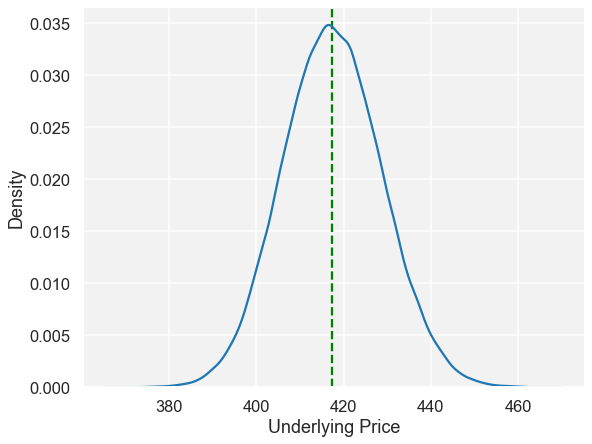

In [45]:
# STOPPED HERE. POP LOOKS GOOD, I THINK STRIKES ARE CORRECT. NEED TO FIX BEP, P50, MAX G/L, ETC.
puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + (r - q + x["iv"]**2/2) * t) / (x["iv"]*math.sqrt(t)), axis=1)
puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(t), axis=1)
puts["delta"] = puts["d1"].apply(lambda x: math.exp(-q*t) * norm.cdf(x) - 1)
puts["spot_diff"] = abs(puts["strike"] - spot)
atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

puts["delta_diff"] = abs(puts["delta"] + short_delta)
short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
short_put_strike = short_put["strike"]
print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")

puts["long_diff"] = abs(puts["strike"] - (short_put_strike - spread))
long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
long_put_strike = long_put["strike"]
lower_dollars_otm = short_put_strike - spot

# Calculate price based on BS or BOPM
theoretical_short = strat._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff=payoff)
theoretical_long = strat._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff=payoff)
net_theoretical = theoretical_short - theoretical_long

# find spreads and mid points
spread = short_put_strike - long_put_strike
net_credit = float(short_put["midpoint"])-float(long_put["midpoint"]) - total_commissions/100

# calculate gain, loss, credit pct of width
max_gain = (net_credit * 100 * n_contracts)
max_loss = 100*n_contracts*(spread - net_credit) # hopefully ~ 30% of width
max_loss_gross = 100*n_contracts*(spread)

lower_breakeven = float(short_put["strike"] - net_credit)
lower_fifty = short_put["strike"] - net_credit / 2
lower_twox_credit = lower_breakeven - net_credit*2  # Does this make sense. E.g. if max loss is 1100, this is 550 (one half)

### p50 is half of the max gain above (below) short call (put). neg p50 is half loss above (below) long call (put)
dte = t * 365.25
future_sigma = sigma / math.sqrt(252/dte)
future_prices = mc_asset_price(spot, sigma=future_sigma, r=r, t=t, q=q, n_paths=n_paths)
profits = np.where(future_prices>lower_breakeven, 1, 0)

profit_dollars = np.where(future_prices>lower_breakeven, net_credit, future_prices-lower_breakeven)
profit_dollars = profit_dollars.clip(-spread, net_credit)

fifty_percents = np.where(future_prices[profits==1]>lower_fifty, 1, 0)
twox_credit_losses = np.where(future_prices < lower_twox_credit, 1, 0)  # or
pop = float(np.sum(profits) / profits.shape)    
p50 = float(np.sum(fifty_percents) / fifty_percents.shape)
neg_p50 = float(np.sum(twox_credit_losses) / twox_credit_losses.shape)
credit_to_bpr = 100*max_gain / max_loss
expected_move = spot*sigma*math.sqrt(t)

open_interest = [short_put["oi"], long_put["oi"]]
volumes = [short_put["volume"], long_put["volume"]]
if any(open_interest) == 0 or any(volumes) == 0:
    print("WARNING: this trade lacks sufficient liquidity.")
current_mom = ticker_momentum(ticker, window=mom_window)

print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
print(f"Credit/BPR: {credit_to_bpr:.2f}%")

if verbose:  # can filter out some of the verbiage if needed
    print(f"Limit Order based on midpoint is: {net_credit:.2f}")
    print(f"Limit Order based on theoretical price is: {net_theoretical:.2f}")
    print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
    print(f"Lower breakeven is: {lower_breakeven}")
    print(f"Percent of Profit is: {pop*100:.2f}%")
#             print(f"P50 is: {p50*100:.2f}%")
    print(f"Percent of loss exceeding 2x credit: {neg_p50*100:.2f}%\n------------------------------------------------------\n")
    print(f"Historical Annualized Vol: {sigma*100:.2f}%")



In [18]:
def kelly_criterion(pop, capital_requirement, max_gain):
    """ uses kelly criterion to calculate bet size for give position """
    b = max_gain / capital_requirement
    f = (pop * (b+1) - 1) / b
    
    return f


capital_requirement = spread - net_credit
# profit_dollars = np.where(future_prices<lower_breakeven, future_prices, 0)

In [8]:
### NEW MC?
t = 50/365.25
sigma = .285
S0 = 40.7
short_K = 37
long_K = 33
n_paths = 10000000  # Number of random variables
r = 0.001

W = stats.norm.rvs( (r-0.5*sigma**2)*t , np.sqrt(t)*sigma, n_paths)
S_T = S0 * np.exp(W)  # future prices

short_put = scipy.mean( np.exp(-r*t) * np.maximum(short_K-S_T,0) )
long_put = scipy.mean( np.exp(-r*t) * np.maximum(long_K-S_T,0) )

net_credit = short_put - long_put
lower_breakeven = short_K - net_credit
spread = short_K - long_K

C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  del sys.path[0]
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  


In [2]:
def mc_asset_price(s, sigma, r, t, q, n_paths=100000, plot=True):

In [77]:
t = 50 / 365.25
q = 0.0133
sigma = .16
r = 0.002
s = 419.79
n_paths = 10000

short_put_strike = 400
long_put_strike = 395
net_credit = 1.5
spread = 5
verbose = True

In [82]:
# mc_asset_price(s, sigma, r, t, q, n_paths, plot=False)
w = stats.norm.rvs( (r-0.5*sigma**2)*t , np.sqrt(t)*sigma, n_paths)
future_prices = s * np.exp(w)

future_prices = np.array(future_prices)
skew = stats.skew(future_prices)

In [84]:
profits = np.where(future_prices>lower_breakeven, 1, 0)

# get theoretical prices
sim_short_price = scipy.mean(np.exp(-r*t) * np.maximum(short_put_strike - future_prices, 0))
sim_long_price = scipy.mean(np.exp(-r*t) * np.maximum(long_put_strike - future_prices, 0))
sim_spread = sim_short_price - sim_long_price

profit_dollars = np.where(future_prices>lower_breakeven, net_credit, future_prices-lower_breakeven)
profit_dollars = profit_dollars.clip(-spread, net_credit)

pop = float(np.sum(profits) / profits.shape)   

if verbose:  # can filter out some of the verbiage if needed
    print(f"Percent of Profit is: {pop*100:.2f}%")
    print(f"Expected P&L: {profit_dollars.mean():.2f}")


Percent of Profit is: 80.50%
Expected P&L: 0.37


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  after removing the cwd from sys.path.
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  """


In [81]:
future_prices[0]

array([444.6275148 , 431.58871743, 395.533014  , ..., 414.94573067,
       437.40051632, 411.55385132])